In [1]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/minor/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/minor/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` 

In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Define same architecture used during training
class CovidDenseNet(nn.Module):
    def __init__(self, num_classes=3):
        super(CovidDenseNet, self).__init__()
        # Load DenseNet201 backbone
        self.backbone = models.densenet201(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        # Replace classifier
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Instantiate model
model = CovidDenseNet(num_classes=3)

# Load trained weights
checkpoint = torch.load("models/chexnet201_finetuned.pth", map_location="cpu")
model.load_state_dict(checkpoint)
model.eval()

/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/fz/sd4mlm5j5xq82d0vlcyb4sgm0000gn/T/ipykernel_1598/1558867835.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defaul

CovidDenseNet(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [3]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: COVID-19
Probabilities: [0.8445804119110107, 0.10296307504177094, 0.0524565726518631]


# image covid-19

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def gradcam_last_conv_covid(model, img_path, transform):
    """
    Apply Grad-CAM on the last convolutional layer of DenseNet201 (CPU-only)
    focusing specifically on the 'COVID-19' class.

    Args:
        model: CovidDenseNet model (DenseNet201 backbone)
        img_path: Path to input image
        transform: Preprocessing transform (same as used during training)
    Returns:
        (grayscale_cam, overlay_image)
    """

    # Force CPU-only execution (safe for Mac M1)
    device = 'cpu'
    model.to(device)
    model.eval()

    # 🔹 Load and preprocess image
    rgb_img = np.float32(Image.open(img_path).convert('RGB').resize((224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # 🔹 Target the *last convolutional layer* in DenseNet201
    target_layer = model.backbone.features.denseblock4
    
    # 🔹 Initialize GradCAM (CPU mode)
    cam = GradCAM(model=model, target_layers=[target_layer])

    # 🔹 Set target to COVID-19 class (index 0)
    targets = [ClassifierOutputTarget(0)]

    # 🔹 Generate Grad-CAM for the COVID-19 class
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # 🔹 Normalize the heatmap to [0, 1]
    grayscale_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)

    # 🔹 Overlay heatmap on the original image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 🔹 Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(rgb_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("COVID-19 Grad-CAM Heatmap")
    plt.imshow(grayscale_cam, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay (COVID-19 Class)")
    plt.imshow(visualization)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return grayscale_cam, visualization


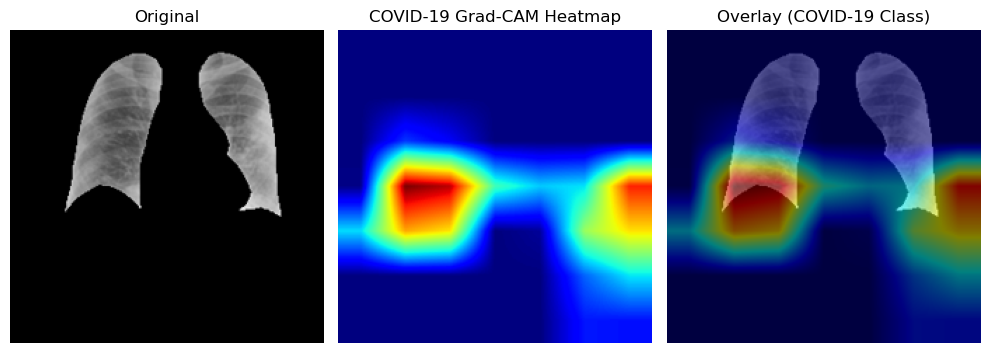

In [5]:
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
cam, overlay = gradcam_last_conv_covid(model, img_path, transform)

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def compare_gradcam_layers_extended_densenet201(model, img_path, transform):
    """
    Compare Grad-CAM outputs across valid convolutional layers of DenseNet201.
    Safe version: only includes existing layer names for DenseNet201.
    """

    device = 'cpu'
    model.to(device)
    model.eval()

    # 🔹 Load & preprocess image
    rgb_img = np.float32(Image.open(img_path).convert('RGB').resize((224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # 🔹 Candidate layers (verified for DenseNet201)
    candidate_layers = {
        # Early feature layers — high spatial detail
        "denseblock1.denselayer6.conv2": model.backbone.features.denseblock1.denselayer6.conv2,
        "denseblock2.denselayer6.conv2": model.backbone.features.denseblock2.denselayer6.conv2,
        "denseblock2.denselayer12.conv2": model.backbone.features.denseblock2.denselayer12.conv2,

        # Mid-level features — lung structure, shapes
        "denseblock3.denselayer10.conv2": model.backbone.features.denseblock3.denselayer10.conv2,
        "denseblock3.denselayer20.conv2": model.backbone.features.denseblock3.denselayer20.conv2,
        "denseblock3.denselayer32.conv2": model.backbone.features.denseblock3.denselayer32.conv2,
        "denseblock3.denselayer48.conv2": model.backbone.features.denseblock3.denselayer48.conv2,

        # Deep features — high-level disease activations
        "denseblock4.denselayer6.conv2":  model.backbone.features.denseblock4.denselayer6.conv2,
        "denseblock4.denselayer16.conv2": model.backbone.features.denseblock4.denselayer16.conv2,  # ⭐ often best
        "denseblock4.denselayer24.conv2": model.backbone.features.denseblock4.denselayer24.conv2,
        "denseblock4.denselayer26.conv2": model.backbone.features.denseblock4.denselayer26.conv2,
        "denseblock4.denselayer28.conv2": model.backbone.features.denseblock4.denselayer28.conv2,
        "denseblock4.denselayer30.conv2": model.backbone.features.denseblock4.denselayer30.conv2,
        "denseblock4.denselayer32.conv2": model.backbone.features.denseblock4.denselayer32.conv2
    }

    targets = [ClassifierOutputTarget(0)]  # COVID-19 class
    n_layers = len(candidate_layers)
    n_cols = 3
    n_rows = int(np.ceil((n_layers + 1) / n_cols))

    plt.figure(figsize=(18, n_rows * 5))

    # 🔹 Original Image
    plt.subplot(n_rows, n_cols, 1)
    plt.title("Original Image")
    plt.imshow(rgb_img)
    plt.axis('off')

    # 🔹 Generate Grad-CAM for each layer
    for idx, (name, layer) in enumerate(candidate_layers.items(), start=2):
        cam = GradCAM(model=model, target_layers=[layer])
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        # Normalize heatmap
        grayscale_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(n_rows, n_cols, idx)
        plt.title(name)
        plt.imshow(visualization)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


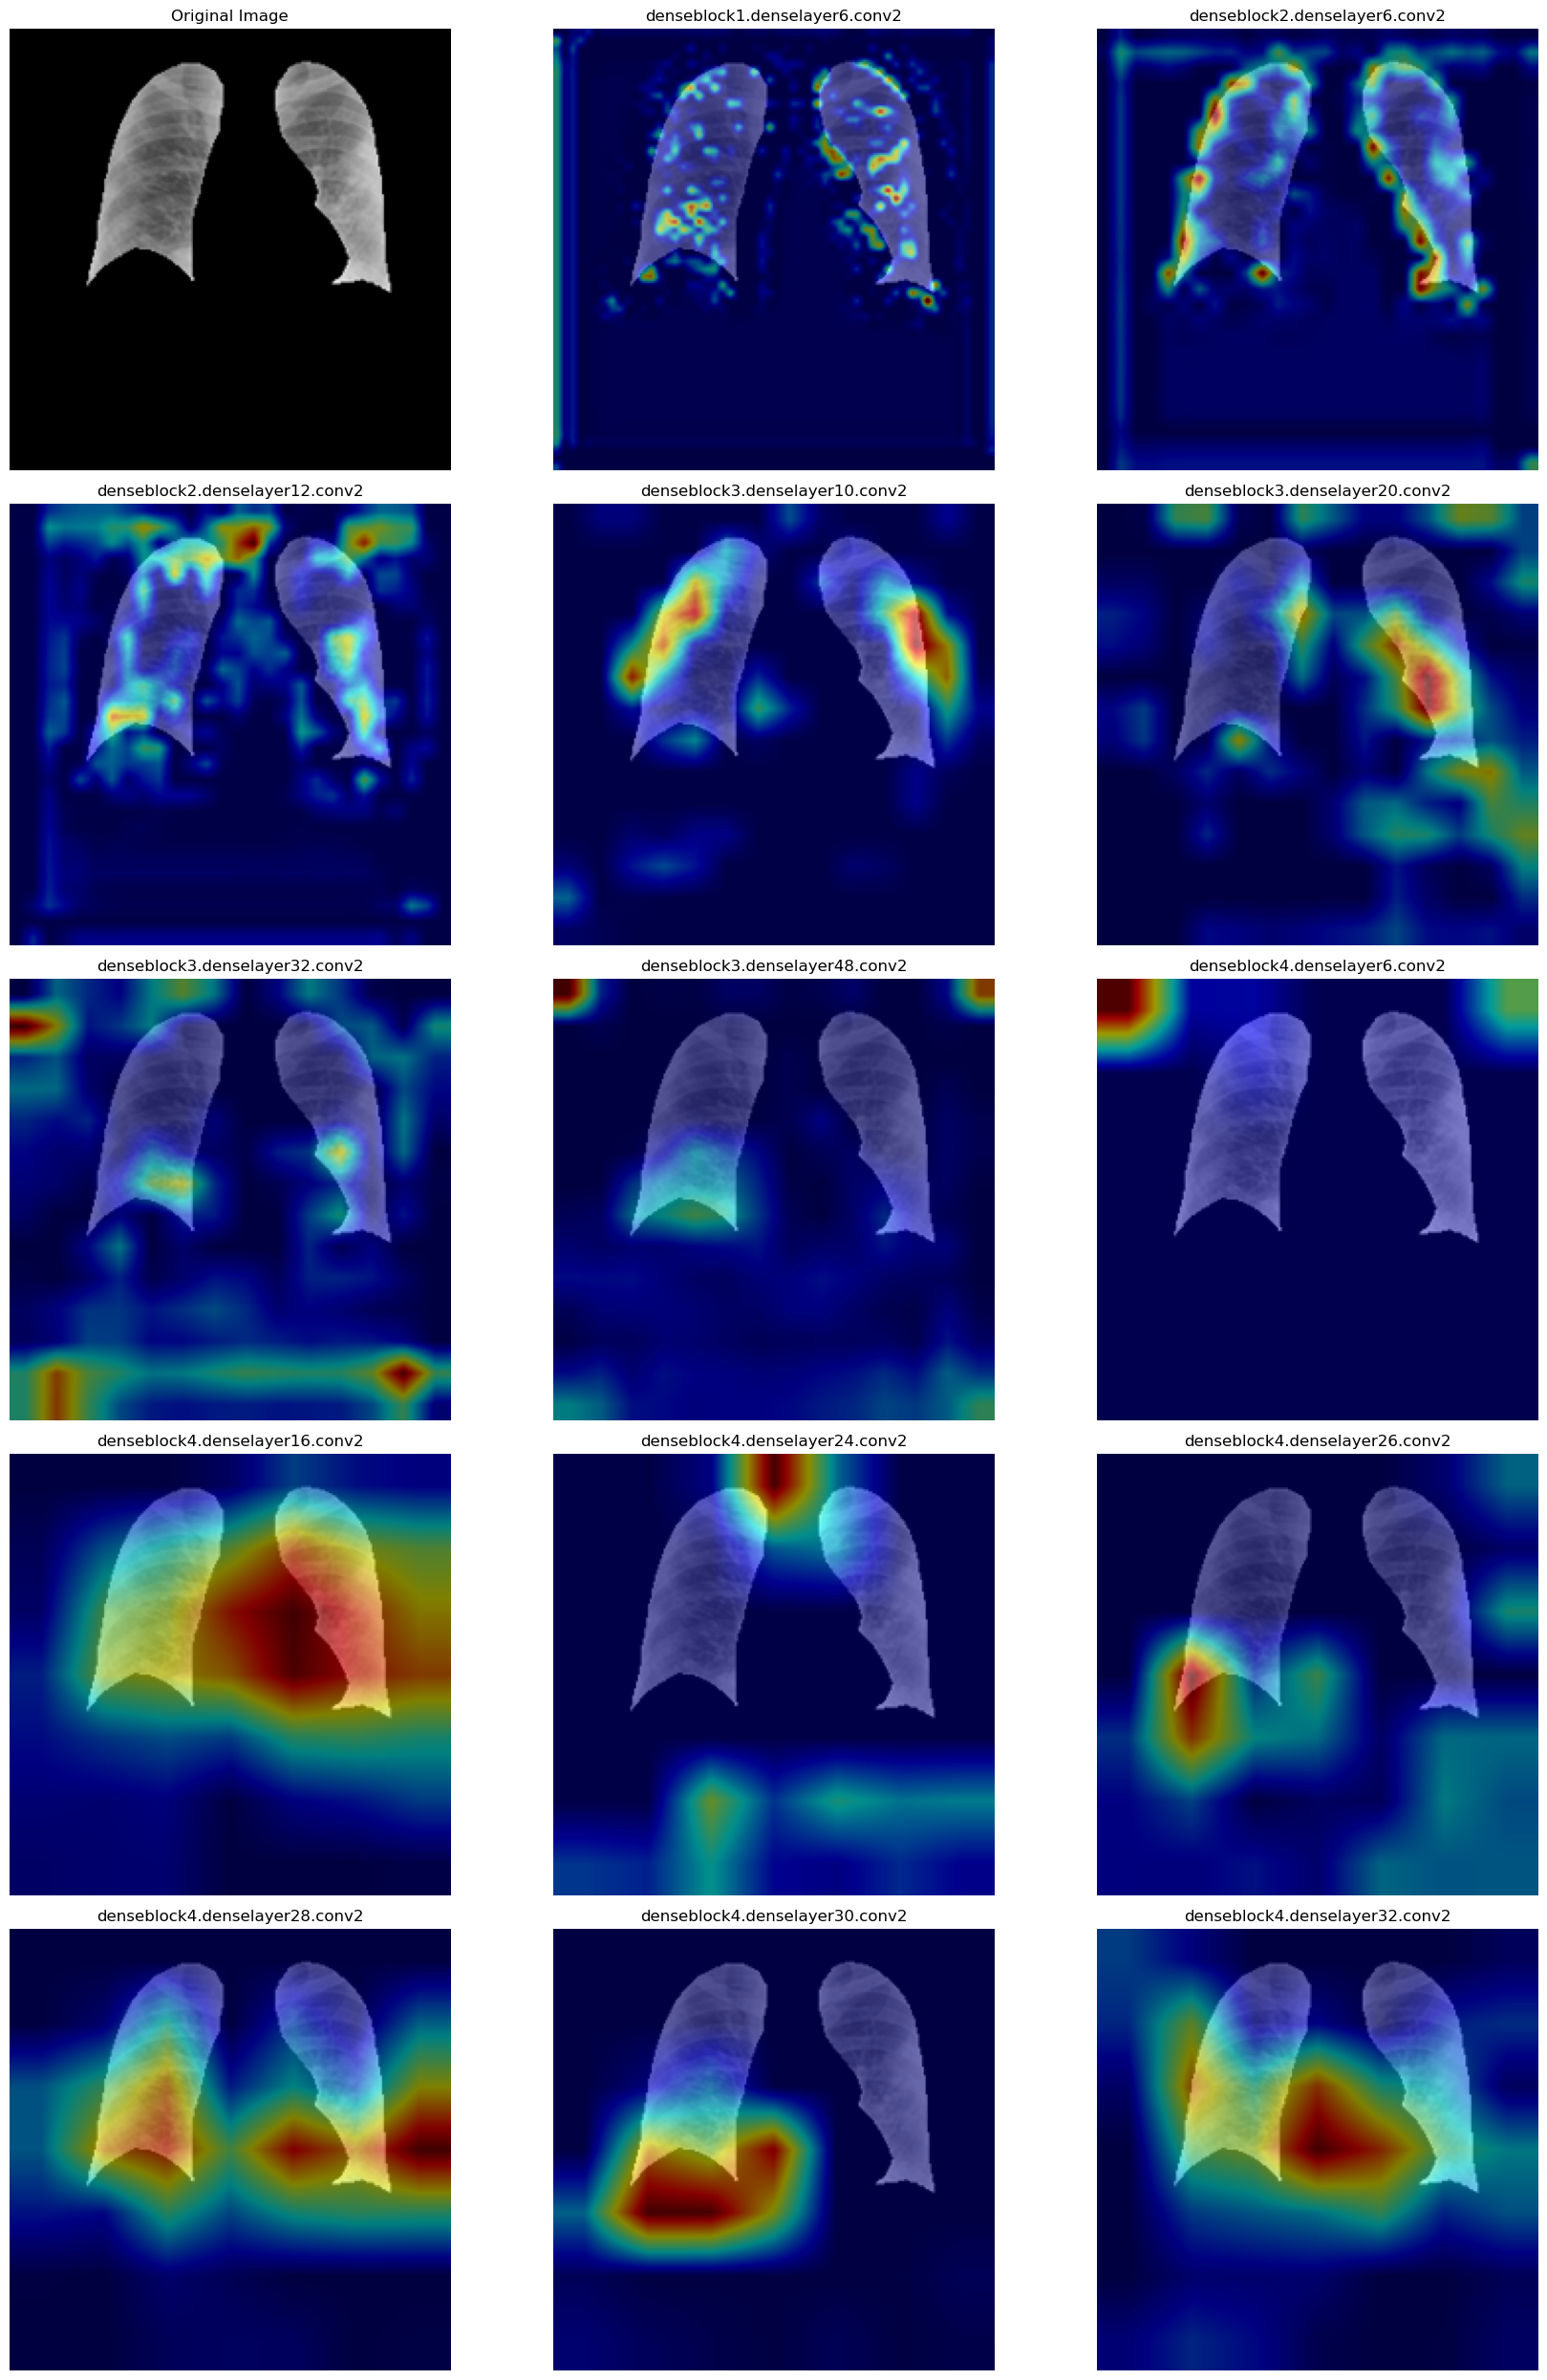

In [15]:
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
compare_gradcam_layers_extended_densenet201(model, img_path, transform)

# predicting infection mask

In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def gradcam_infection_mask(model, img_path, transform, threshold=0.5):
    """
    Generate a binary infection mask (white = infected region, black = rest)
    using Grad-CAM for the COVID-19 class.

    Args:
        model: Trained DenseNet121 model
        img_path: Path to lung-segmented input image
        transform: Same preprocessing transform as training
        threshold: Float (0–1), cutoff for infection activation

    Returns:
        binary_mask: np.ndarray (uint8, shape [H, W]) — white infection, black otherwise
    """

    device = 'cpu'
    model.to(device)
    model.eval()

    # Load image
    orig_img = np.array(Image.open(img_path).convert("RGB"))
    rgb_img = np.float32(cv2.resize(orig_img, (224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # Use deep layer — good for infection localization
    target_layer = model.backbone.features.denseblock4.denselayer16.conv2

    # Generate Grad-CAM heatmap
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0, :]  # COVID class = 0

    # Normalize
    heatmap = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)

    # Resize back to original image
    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

    # Threshold Grad-CAM to isolate infection
    infection_mask = np.uint8(heatmap_resized > threshold)

    # Extract lung segmentation mask from image (assuming lungs are brighter than background)
    gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    lung_mask = np.uint8(gray > 10)  # non-black pixels → lung region

    # Apply lung mask to infection mask
    infection_mask = infection_mask * lung_mask

    # Convert to binary (white/black)
    infection_binary = np.uint8(infection_mask * 255)

    # Optional: smooth edges
    infection_binary = cv2.medianBlur(infection_binary, 5)

    return infection_binary


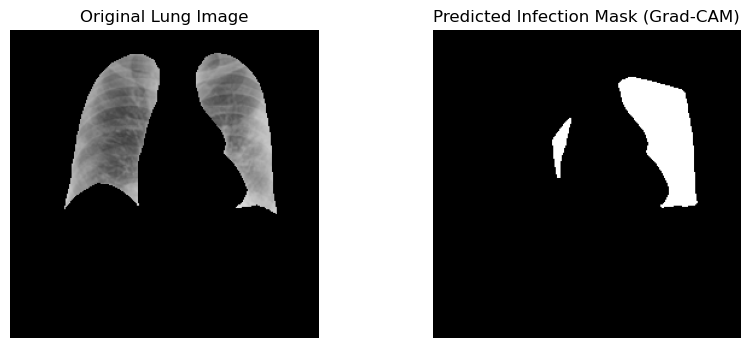

In [24]:
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
infection_mask = gradcam_infection_mask(model, img_path, transform, threshold=0.6)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Lung Image")
plt.imshow(Image.open(img_path))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Infection Mask (Grad-CAM)")
plt.imshow(infection_mask, cmap='gray')
plt.axis('off')
plt.show()


# Predict and save infection maks

In [37]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# === CONFIGURATION ===
test_folder = "covid_qu_ex_masked/test/COVID-19"
save_root = "predicted_infection_masks/GradCAM_cheXCaps201/test/COVID-19"
os.makedirs(save_root, exist_ok=True)

# Use the desired Grad-CAM layer and threshold
target_layer = model.backbone.features.denseblock4.denselayer16.conv2
threshold = 0.6

# CPU mode
device = 'cpu'
model.to(device)
model.eval()

# === FUNCTION: Generate Binary Infection Mask ===
def generate_gradcam_mask(model, img_path, transform, target_layer, threshold=0.6):
    """Generate binary infection mask (white=infection, black=normal) using Grad-CAM."""
    
    # Load image and preprocess
    orig_img = np.array(Image.open(img_path).convert("RGB"))
    rgb_img = np.float32(cv2.resize(orig_img, (224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)
    
    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0, :]  # COVID-19 class
    
    # Normalize Grad-CAM
    heatmap = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)
    
    # Resize to original image size
    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    
    # Binary thresholding
    infection_mask = np.uint8(heatmap_resized > threshold)
    
    # Extract lung mask from input image (non-black pixels)
    gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    lung_mask = np.uint8(gray > 10)
    
    # Restrict infection mask to lung region
    infection_mask = infection_mask * lung_mask
    
    # Convert to binary white/black
    infection_binary = np.uint8(infection_mask * 255)
    
    # Optional smoothing
    infection_binary = cv2.medianBlur(infection_binary, 5)
    
    return infection_binary

In [38]:
image_files = [f for f in os.listdir(test_folder) if f.endswith((".png", ".jpg"))]

for filename in tqdm(image_files, desc="Generating Grad-CAM infection masks", unit="image"):
    img_path = os.path.join(test_folder, filename)
    try:
        infection_mask = generate_gradcam_mask(model, img_path, transform, target_layer, threshold)
        save_path = os.path.join(save_root, filename)
        cv2.imwrite(save_path, infection_mask)
    except Exception as e:
        print(f"⚠️ Skipping {filename}: {e}")

print(f"✅ {len(image_files)} Grad-CAM infection masks saved successfully in '{save_root}'")


Generating Grad-CAM infection masks: 100%|██████████| 583/583 [03:29<00:00,  2.79image/s]

✅ 583 Grad-CAM infection masks saved successfully in 'predicted_infection_masks/GradCAM_cheXCaps201/test/COVID-19'


In [39]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) > 0 else 1.0

def hausdorff_distance(y_true, y_pred):
    true_points = np.column_stack(np.where(y_true))
    pred_points = np.column_stack(np.where(y_pred))
    if len(true_points) == 0 or len(pred_points) == 0:
        return np.nan
    forward_hd = directed_hausdorff(true_points, pred_points)[0]
    backward_hd = directed_hausdorff(pred_points, true_points)[0]
    return max(forward_hd, backward_hd)

In [40]:
def evaluate_mask_metrics(gt_folder, pred_folder):
    gt_files = {f for f in os.listdir(gt_folder) if f.endswith(('.png', '.jpg'))}
    pred_files = {f for f in os.listdir(pred_folder) if f.endswith(('.png', '.jpg'))}

    # Find common filenames present in both folders
    common_files = sorted(list(gt_files & pred_files))

    if not common_files:
        print("No matching filenames found between predicted and ground truth folders.")
        return None

    metrics = {
        'iou': [], 'dice': [], 'accuracy': [],
        'precision': [], 'recall': [], 'f1_score': [], 'hausdorff': []
    }

    for filename in common_files:
        gt_path = os.path.join(gt_folder, filename)
        pred_path = os.path.join(pred_folder, filename)

        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        if gt_mask is None or pred_mask is None:
            continue  # Skip any missing file read
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))

        # Convert to binary 0-1
        gt_mask = (gt_mask > 0).astype(np.uint8)
        pred_mask = (pred_mask > 0).astype(np.uint8)

        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()

        metrics['iou'].append(iou_score(gt_mask, pred_mask))
        metrics['dice'].append(dice_score(gt_mask, pred_mask))
        metrics['accuracy'].append(accuracy_score(gt_flat, pred_flat))
        metrics['precision'].append(precision_score(gt_flat, pred_flat, zero_division=0))
        metrics['recall'].append(recall_score(gt_flat, pred_flat, zero_division=0))
        metrics['f1_score'].append(f1_score(gt_flat, pred_flat, zero_division=0))
        metrics['hausdorff'].append(hausdorff_distance(gt_mask, pred_mask))

    avg_metrics = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg_metrics


# Example usage
ground_truth_folder = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks"
predicted_mask_folder = "predicted_infection_masks/GradCAM_cheXCaps201/test/COVID-19"

results = evaluate_mask_metrics(ground_truth_folder, predicted_mask_folder)

if results:
    print("\n📊 Evaluation results for Grad-CAM infection masks:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")


📊 Evaluation results for Grad-CAM infection masks:
iou: 0.2331
dice: 0.3452
accuracy: 0.8787
precision: 0.5732
recall: 0.3091
f1_score: 0.3452
hausdorff: 112.0827
